In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
from tqdm import tqdm

from settings import INPUTS_PATH
import matplotlib.pyplot as plt


plt.style.use('ggplot')

/Users/danieloliveira/opt/anaconda3/envs/vae-ssm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(os.path.join(INPUTS_PATH, 'mixed_freq_df.csv'))
df.set_index('date', inplace=True)

df.tail()

,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
date,,,,,,,,,,,,,
2021-08-01,0.003286,NaN,0.002744,-0.037037,0.007042,-0.001632,-0.001062,0.001018,0.003135,0.003824,0.055828,NaN,NaN
2021-09-01,0.002570,0.005709,0.004124,-0.096154,-0.014622,-0.009759,-0.016185,0.002431,0.002405,0.003465,-0.078443,0.023111,0.014297
2021-10-01,0.004383,NaN,0.009433,-0.021277,0.001290,0.012333,-0.001650,0.005992,0.004427,0.006487,0.042245,NaN,NaN
2021-11-01,0.001677,NaN,0.007791,-0.086957,0.081186,0.007375,-0.001950,0.005346,0.004803,0.006266,0.038717,NaN,NaN
2021-12-01,0.001338,0.016791,0.004705,-0.071429,0.014303,-0.001024,-0.002285,0.005501,0.004981,0.004476,0.097845,NaN,NaN


## RNN with Univariate Time Series

### Dataset

<Axes: xlabel='date'>

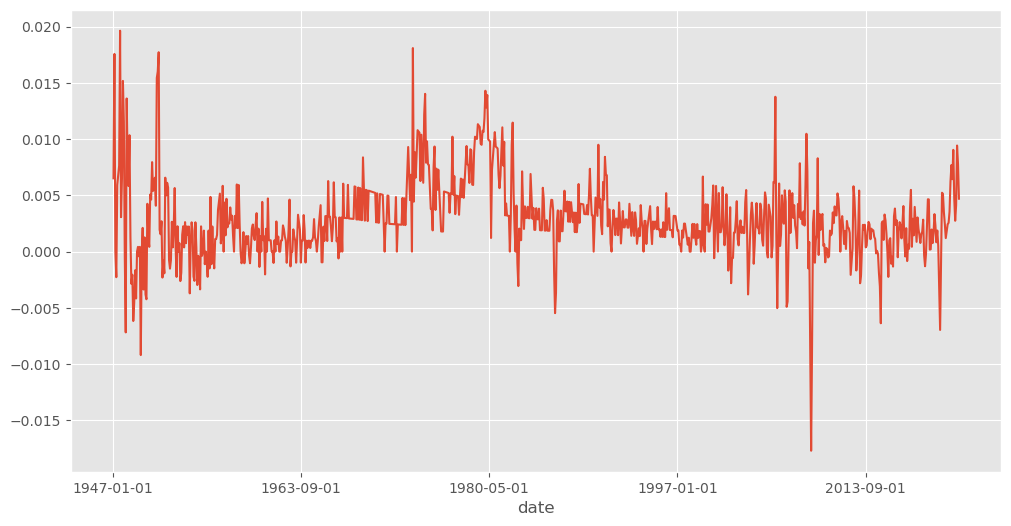

In [3]:
y = df["cpiaucsl"]

y.plot(figsize=(12, 6))

### Single pass of the RNN

In [4]:
input_size = 1
hidden_size = 10
num_layers = 1
batch_first = True

# dim: [num_batches, seq_len, input_size]
y_tensor = torch.tensor(df["cpiaucsl"].dropna().to_numpy())[None, :, None].to(torch.float32)

rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=batch_first)
linear = nn.Linear(hidden_size, input_size)

t = 0
y_t = y_tensor[:, 0:1, :]

b, T, d = y_t.shape

h0 = torch.randn(b, T, hidden_size)
o_t, h_t = rnn(y_t, h0)

y_t1 = linear(o_t)

### Multiple passes pass of the RNN

In [5]:
input_size = 1
hidden_size = 10
num_layers = 5
batch_first = True
fix_start = True
learning_rate = 0.01

target_df = df[["cpiaucsl"]].dropna()

# dim: [num_batches, seq_len, input_size]
y_tensor = torch.tensor(target_df.to_numpy())[None, :].to(torch.float32)
b, T, d = y_tensor.shape


class RNN(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 num_layers: int,
                 batch_first: bool=True) -> None:
        super().__init__()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=batch_first, bias=False)
        self.linear = nn.Linear(hidden_size, input_size, bias=False)

    def forward(self,
                x: torch.Tensor,
                h0: torch.Tensor) -> torch.Tensor:
         # forward pass
        o_t, h_t = self.rnn(x, h0)

        # apply output to linear layer
        o_t = self.linear(o_t)

        return o_t, h_t

# model setup
model = RNN(input_size, hidden_size, num_layers, batch_first=batch_first)

# loss function
loss_fn = nn.MSELoss()

# optimizer
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

preds = []
hiddens = []
losses = []
for t in tqdm(range(0, T-1), desc='Training RNN'):

    # random init for hidden state or use previous one
    if t == 0:
        h0 = torch.randn(num_layers, 1, hidden_size)
    else:
        h0 = h_t

    # train data
    y_t = y_tensor[:, t:(t+1), :]

    # test data
    y_true = y_tensor[:, (t+1):(t+2), :]

    y_t1, h_t = model(y_t, h0)

    # apply loss function
    loss = loss_fn(y_t1, y_true)

    # backprop
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()   

    # store predictions
    preds.append(y_t1.detach())

    # store hidden states
    hiddens.append(h_t.detach())

    # store loss
    losses.append(loss.detach().reshape(1, 1))
    
preds = torch.cat(preds, dim=1) 
hiddens = torch.cat(hiddens, dim=1)
losses = torch.cat(losses, dim=1)

Training RNN: 100%|██████████| 898/898 [01:31<00:00,  9.77it/s]


Text(0.5, 1.0, 'CPI vs Predicted CPI')

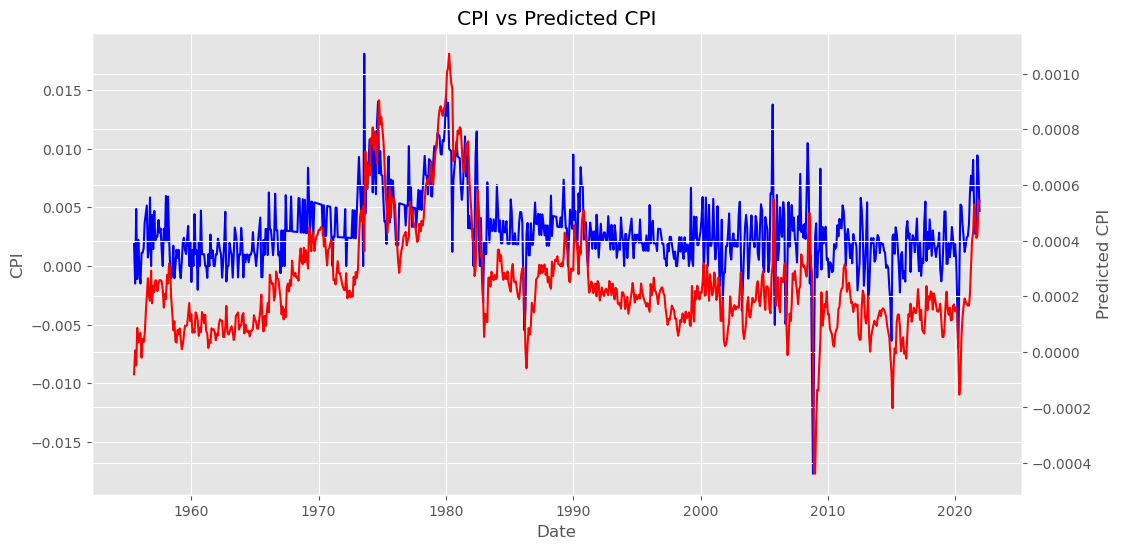

In [6]:
preds_df = pd.DataFrame(preds.numpy().squeeze()[100:], columns=["preds"], index=target_df.index[101:])
plot_df = pd.concat([target_df.iloc[101:, ], preds_df], axis=1)
plot_df.index = pd.to_datetime(plot_df.index)

# two y-axes plot and shared x-axis
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(plot_df["cpiaucsl"], color="blue")
ax2.plot(plot_df["preds"], color="red")
ax1.set_ylabel("CPI")
ax2.set_ylabel("Predicted CPI")
ax1.set_xlabel("Date")
plt.title("CPI vs Predicted CPI")